# Detectron2 Check

If this is your first time running this notebook, the required library versions will not be installed. The notebook will restart and you'll have to click the "Run All" button again.

In [ ]:
try:
    import detectron2
    print(f"Found detectron2: {detectron2.__version__}")
except ImportError:
    print("Could not find detectron2. Installing now...")
    # Install pyyaml
    !pip install pyyaml==5.1
    # Install Detectron2
    !pip install 'git+https://github.com/facebookresearch/detectron2.git'
    # Install Panoptic API from COCO
    !pip install git+https://github.com/cocodataset/panopticapi.git

    # Restart the runtime
    import os
    print("Stopping Runtime! Please run again!")
    os.kill(os.getpid(), 9)

detectron2: 0.6


# Configuration

### Define parameters of how you want to run your training

In [ ]:
# Dataset to train the model on (can be "RUGD", "Rellis", or "Combined")
DATASET_NAME = "Combined"

# Panoptic Model to train (can be "FPN_50_1x", "FPN_50_3x", or "FPN_101_3x")
PANOPTIC_MODEL = "FPN_101_3x"

# Iterations to run panoptic model training
TRAINING_ITERATIONS = 16000

In [ ]:
download_links = {
    "RUGD":     "1cuDAXrwG9NY4d4qsBy8h3OkzTmo2u3WE",
    "Rellis":   "1QVag_I9iAmpvCa-9EHYxnQsDKLJo0Y1D",
    "Combined": "1nBapUf3t4N71YOFXHKmLpAGoyfmITJqc",
}
detectron_panoptic_models = {
    "FPN_50_1x":  "COCO-PanopticSegmentation/panoptic_fpn_R_50_1x.yaml",
    "FPN_50_3x":  "COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml",
    "FPN_101_3x": "COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml",
}

DATASET_NAMES = ["RUGD", "Rellis", "Combined"]
gdrive_links = [download_links[key] for key in DATASET_NAMES]
detectron_zoo_model = detectron_panoptic_models[PANOPTIC_MODEL]
configuration_name = f"{DATASET_NAME}-{PANOPTIC_MODEL}"

print(gdrive_links)
print(configuration_name)

['1cuDAXrwG9NY4d4qsBy8h3OkzTmo2u3WE', '1QVag_I9iAmpvCa-9EHYxnQsDKLJo0Y1D', '1nBapUf3t4N71YOFXHKmLpAGoyfmITJqc']
Combined-FPN_101_3x


## Import libraries

In [ ]:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# Import some common libraries
from google.colab.patches import cv2_imshow
from typing import List, Optional
import numpy as np
import cv2
import json
import os
import random
import ssl

# Import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import build_detection_test_loader, DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_panoptic_separated
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.evaluation import inference_on_dataset
from detectron2.evaluation.panoptic_evaluation import COCOPanopticEvaluator
from detectron2.utils.visualizer import Visualizer

detectron2: 0.6


In [ ]:
dataset_path = "datasets"

if not os.path.exists(dataset_path):
    os.mkdir(dataset_path)

# Datasets

## Download the preprocessed datasets

In [ ]:
# Download RUGD
!gdown ${"1" + gdrive_links[0]}

Downloading...
From: https://drive.google.com/uc?id=1cuDAXrwG9NY4d4qsBy8h3OkzTmo2u3WE
To: /content/RUGD.zip
100% 870M/870M [00:04<00:00, 177MB/s]


In [ ]:
# Download Rellis
!gdown ${"1" + gdrive_links[1]}

Downloading...
From: https://drive.google.com/uc?id=1QVag_I9iAmpvCa-9EHYxnQsDKLJo0Y1D
To: /content/Rellis.zip
100% 5.80G/5.80G [00:44<00:00, 130MB/s]


In [ ]:
# Download Combined
!gdown ${"1" + gdrive_links[2]}

Downloading...
From: https://drive.google.com/uc?id=1nBapUf3t4N71YOFXHKmLpAGoyfmITJqc
To: /content/Combined.zip
100% 6.68G/6.68G [00:31<00:00, 212MB/s]


## Extract the datasets

In [ ]:
zipped_files = [f"{key}.zip" for key in DATASET_NAMES]
(zipped_rugd, zipped_rellis, zipped_combined) = zipped_files
extracted_paths = [os.path.join(dataset_path, key) for key in DATASET_NAMES]
(extracted_rugd, extracted_rellis, extracted_combined) = extracted_paths

print(zipped_files)
print(extracted_paths)

['RUGD.zip', 'Rellis.zip', 'Combined.zip']
['datasets/RUGD', 'datasets/Rellis', 'datasets/Combined']


In [ ]:
!unzip $zipped_rugd -d $extracted_rugd

Archive:  RUGD.zip
replace datasets/RUGD/images/test/creek_00021.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!unzip $zipped_rellis -d $extracted_rellis

Streaming output truncated to the last 5000 lines.
  inflating: datasets/Rellis/labels/train_panoptic/frame004105-1581797560_909.png  
  inflating: datasets/Rellis/labels/train_panoptic/frame004107-1581797561_109.png  
  inflating: datasets/Rellis/labels/train_panoptic/frame004115-1581797561_909.png  
  inflating: datasets/Rellis/labels/train_panoptic/frame004119-1581797562_309.png  
  inflating: datasets/Rellis/labels/train_panoptic/frame004123-1581797562_709.png  
  inflating: datasets/Rellis/labels/train_panoptic/frame004127-1581797563_109.png  
  inflating: datasets/Rellis/labels/train_panoptic/frame004129-1581797563_309.png  
  inflating: datasets/Rellis/labels/train_panoptic/frame004133-1581797563_709.png  
  inflating: datasets/Rellis/labels/train_panoptic/frame004137-1581797564_109.png  
  inflating: datasets/Rellis/labels/train_panoptic/frame004139-1581797564_309.png  
  inflating: datasets/Rellis/labels/train_panoptic/frame004141-1581797564_509.png  
  inflating: datasets/Rel

In [ ]:
!unzip $zipped_combined -d $extracted_combined

Streaming output truncated to the last 5000 lines.
  inflating: datasets/Combined/labels/train_semantic/park-1_01821.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01826.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01831.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01836.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01841.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01846.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01851.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01856.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01861.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01866.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01871.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01881.png  
  inflating: datasets/Combined/labels/train_semantic/park-1_01886.png  
  inflating: 

# Panoptic Quality Evaluation

## Register Datasets

In [ ]:
def register_panoptic_datasets(dataset_name: str, dataset_dir: str):
    registered_names = []
    for group in ["train", "test"]:
        registered_name = f"{dataset_name}_{group}_separated"
        register_coco_panoptic_separated(
            name=f"{dataset_name}_{group}",
            metadata={},
            image_root=os.path.join(dataset_dir, "images", group),
            panoptic_root=os.path.join(dataset_dir, "labels", f"{group}_panoptic"),
            panoptic_json=os.path.join(dataset_dir, "labels", f"annotations_{group}_panoptic.json"),
            sem_seg_root=os.path.join(dataset_dir, "labels", f"{group}_semantic"),
            instances_json=os.path.join(dataset_dir, "labels", f"annotations_{group}_instances.json"),
        )

        registered_names.append(registered_name)
    return registered_names

In [ ]:
registered_datasets = []

for dataset, ext_path in zip(DATASET_NAMES, extracted_paths):
    registered_datasets.extend(register_panoptic_datasets(dataset, ext_path))

print(registered_datasets)

['RUGD_train_separated', 'RUGD_test_separated', 'Rellis_train_separated', 'Rellis_test_separated', 'Combined_train_separated', 'Combined_test_separated']


## Update Metadata

In [ ]:
def update_metadata(panoptic_dataset_name: str, data_name: str):
    with open(f"datasets/{data_name}/labels/categories.json") as category_json:
        categories = json.load(category_json)

    thing_classes = [cat["name"] for cat in categories if cat["isthing"] == 1]
    stuff_classes = [cat["name"] for cat in categories if cat["isthing"] == 0]

    thing_ids = [cat["id"] for cat in categories if cat["isthing"] == 1]
    stuff_ids = [cat["id"] for cat in categories if cat["isthing"] == 0]
    thing_dataset_id_to_contiguous_id = {id: index for index, id in enumerate(thing_ids)}
    stuff_dataset_id_to_contiguous_id = {id: index for index, id in enumerate(stuff_ids)}

    metadata = MetadataCatalog.get(panoptic_dataset_name).set(
        thing_classes=thing_classes,
        stuff_classes=stuff_classes,
        thing_dataset_id_to_contiguous_id=thing_dataset_id_to_contiguous_id,
        stuff_dataset_id_to_contiguous_id=stuff_dataset_id_to_contiguous_id,
    )
    print(metadata)


for data_name in registered_datasets:
    update_metadata(data_name, DATASET_NAME)

Metadata(evaluator_type='coco_panoptic_seg', ignore_label=255, image_root='datasets/RUGD/images/train', json_file='datasets/RUGD/labels/annotations_train_instances.json', name='RUGD_train_separated', panoptic_json='datasets/RUGD/labels/annotations_train_panoptic.json', panoptic_root='datasets/RUGD/labels/train_panoptic', sem_seg_root='datasets/RUGD/labels/train_semantic', stuff_classes=['void', 'dirt', 'sand', 'grass', 'tree', 'water', 'sky', 'generic-object', 'asphalt', 'gravel', 'building', 'mulch', 'rock-bed', 'fence', 'bush', 'sign', 'rock', 'bridge', 'concrete', 'barrier', 'mud'], stuff_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20}, thing_classes=['rubble', 'puddle', 'picnic-table', 'log', 'bicycle', 'person', 'vehicle', 'pole'], thing_dataset_id_to_contiguous_id={21: 0, 22: 1, 23: 2, 24: 3, 25: 4, 26: 5, 27: 6, 28: 7})
Metadata(evaluator_type='coco_pa

## Setup Training Config

In [ ]:
def get_config(
    train_datasets: List[str],
    test_datasets: List[str],
    config_name: str,
    zoo_model: str,
    checkpoint: Optional[str] = None,
    offset: int = 0,
    iter_count: int = 3000
):
    cfg = get_cfg()
    print(cfg.OUTPUT_DIR)
    cfg.OUTPUT_DIR = os.path.join(cfg.OUTPUT_DIR, config_name)
    # cfg.MODEL.DEVICE = "cpu"  # Use CPU for debugging

    cfg.merge_from_file(model_zoo.get_config_file(zoo_model))
    cfg.DATASETS.TRAIN = tuple(train_datasets)
    cfg.DATASETS.TEST = tuple(test_datasets)
    cfg.DATALOADER.NUM_WORKERS = 2  # Number of processes to load data
    cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False  # Don't ignore images without instances

    if checkpoint:
        cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR)
    else:
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(zoo_model) # Load in weights from model
    print(cfg.MODEL.WEIGHTS)
    cfg.SOLVER.IMS_PER_BATCH = 6  # Batch size, number of images trained at the same time
    cfg.SOLVER.BASE_LR = 1e-3  # Learning rate
    cfg.SOLVER.MAX_ITER = offset + iter_count  # 3000 ~ 1 hr

    """ When generating semantic images using panopticapi, use the --things_other argument.
        It tells the converter script to set all things to 183 because they are ignored in semantic
        training and evaluation and we tell the model here to ignore pixels with value 183
    """
    cfg.MODEL.SEM_SEG_HEAD.IGNORE_VALUE = 183  # Ignore things classes in semantic head
    
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # Faster (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8  # 8 thing classes
    cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 21  # 21 stuff classes

    cfg.MODEL.PANOPTIC_FPN.COMBINE.OVERLAP_THRESH = 0.5  # (default: 0.5)
    cfg.MODEL.PANOPTIC_FPN.COMBINE.STUFF_AREA_LIMIT = 4096  # (default: 4096)
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.5  # (default: 0.5)
    cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS = [0.50]  # (default: 0.5)

    return cfg

## Train Panoptic Segmentation model

In [ ]:
train_datasets = [registered_datasets[4]]
test_datasets = registered_datasets[1:6:2]

print(train_datasets)
print(test_datasets)

['Combined_train_separated']
['RUGD_test_separated', 'Rellis_test_separated', 'Combined_test_separated']


In [ ]:
model_cfg = get_config(
    train_datasets,
    test_datasets,
    configuration_name,
    detectron_zoo_model,
    iter_count=TRAINING_ITERATIONS,
)

os.makedirs(model_cfg.OUTPUT_DIR, exist_ok=True)
model_trainer = DefaultTrainer(model_cfg)
model_trainer.resume_or_load(resume=False)
model_trainer.train()

./output
https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl
[07/28 00:49:50 d2.engine.defaults]: Model:
PanopticFPN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride

## Evaluate Model

In [ ]:
def evaluate_model(cfg, trainer, data_name: str, test_group: str):
    evaluator = COCOPanopticEvaluator(test_group, output_dir=f"/eval_{data_name}")
    val_loader = build_detection_test_loader(cfg, test_group)
    eval_results = inference_on_dataset(trainer.model, val_loader, evaluator)

In [ ]:
# Evaluate on RUGD
evaluate_model(model_cfg, model_trainer, configuration_name, test_datasets[0])

WARNING [07/28 04:01:04 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/28 04:01:04 d2.data.datasets.coco]: Loaded 1488 images in COCO format from datasets/RUGD/labels/annotations_test_instances.json
WARNING [07/28 04:01:04 d2.data.datasets.coco]: Filtered out 818 instances without valid segmentation. There might be issues in your dataset generation process.  Please check https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html carefully
[07/28 04:01:04 d2.data.datasets.coco]: Loaded 1488 images with semantic segmentation from datasets/RUGD/images/test
[07/28 04:01:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/28 04:01:04 d2.data.common]: Serializing 1488 elements to byte tensors and concatenating them all ...
[07/28 04:01:04 d2.data.common]: Serialized dataset takes 1.75 MiB
[07/28 0

In [ ]:
# Evaluate on Rellis
evaluate_model(model_cfg, model_trainer, configuration_name, test_datasets[1])

WARNING [07/28 04:04:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/28 04:04:30 d2.data.datasets.coco]: Loaded 1247 images in COCO format from datasets/Rellis/labels/annotations_test_instances.json
WARNING [07/28 04:04:30 d2.data.datasets.coco]: Filtered out 182 instances without valid segmentation. There might be issues in your dataset generation process.  Please check https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html carefully
[07/28 04:04:30 d2.data.datasets.coco]: Loaded 1247 images with semantic segmentation from datasets/Rellis/images/test
[07/28 04:04:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/28 04:04:30 d2.data.common]: Serializing 1247 elements to byte tensors and concatenating them all ...
[07/28 04:04:30 d2.data.common]: Serialized dataset takes 1.87 MiB
[07/

In [ ]:
# Evaluate on Combined
evaluate_model(model_cfg, model_trainer, configuration_name, test_datasets[2])

WARNING [07/28 04:13:33 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/28 04:13:33 d2.data.datasets.coco]: Loaded 2735 images in COCO format from datasets/Combined/labels/annotations_test_instances.json
WARNING [07/28 04:13:33 d2.data.datasets.coco]: Filtered out 1000 instances without valid segmentation. There might be issues in your dataset generation process.  Please check https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html carefully
[07/28 04:13:34 d2.data.datasets.coco]: Loaded 2735 images with semantic segmentation from datasets/Combined/images/test
[07/28 04:13:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/28 04:13:34 d2.data.common]: Serializing 2735 elements to byte tensors and concatenating them all ...
[07/28 04:13:34 d2.data.common]: Serialized dataset takes 3.64 MiB

## Display Prediction

In [ ]:
model_cfg.MODEL.WEIGHTS = os.path.join(model_cfg.OUTPUT_DIR, "model_final.pth")
predictor = DefaultPredictor(model_cfg)

[07/28 04:26:43 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

frame003087-1581797459_109.jpg


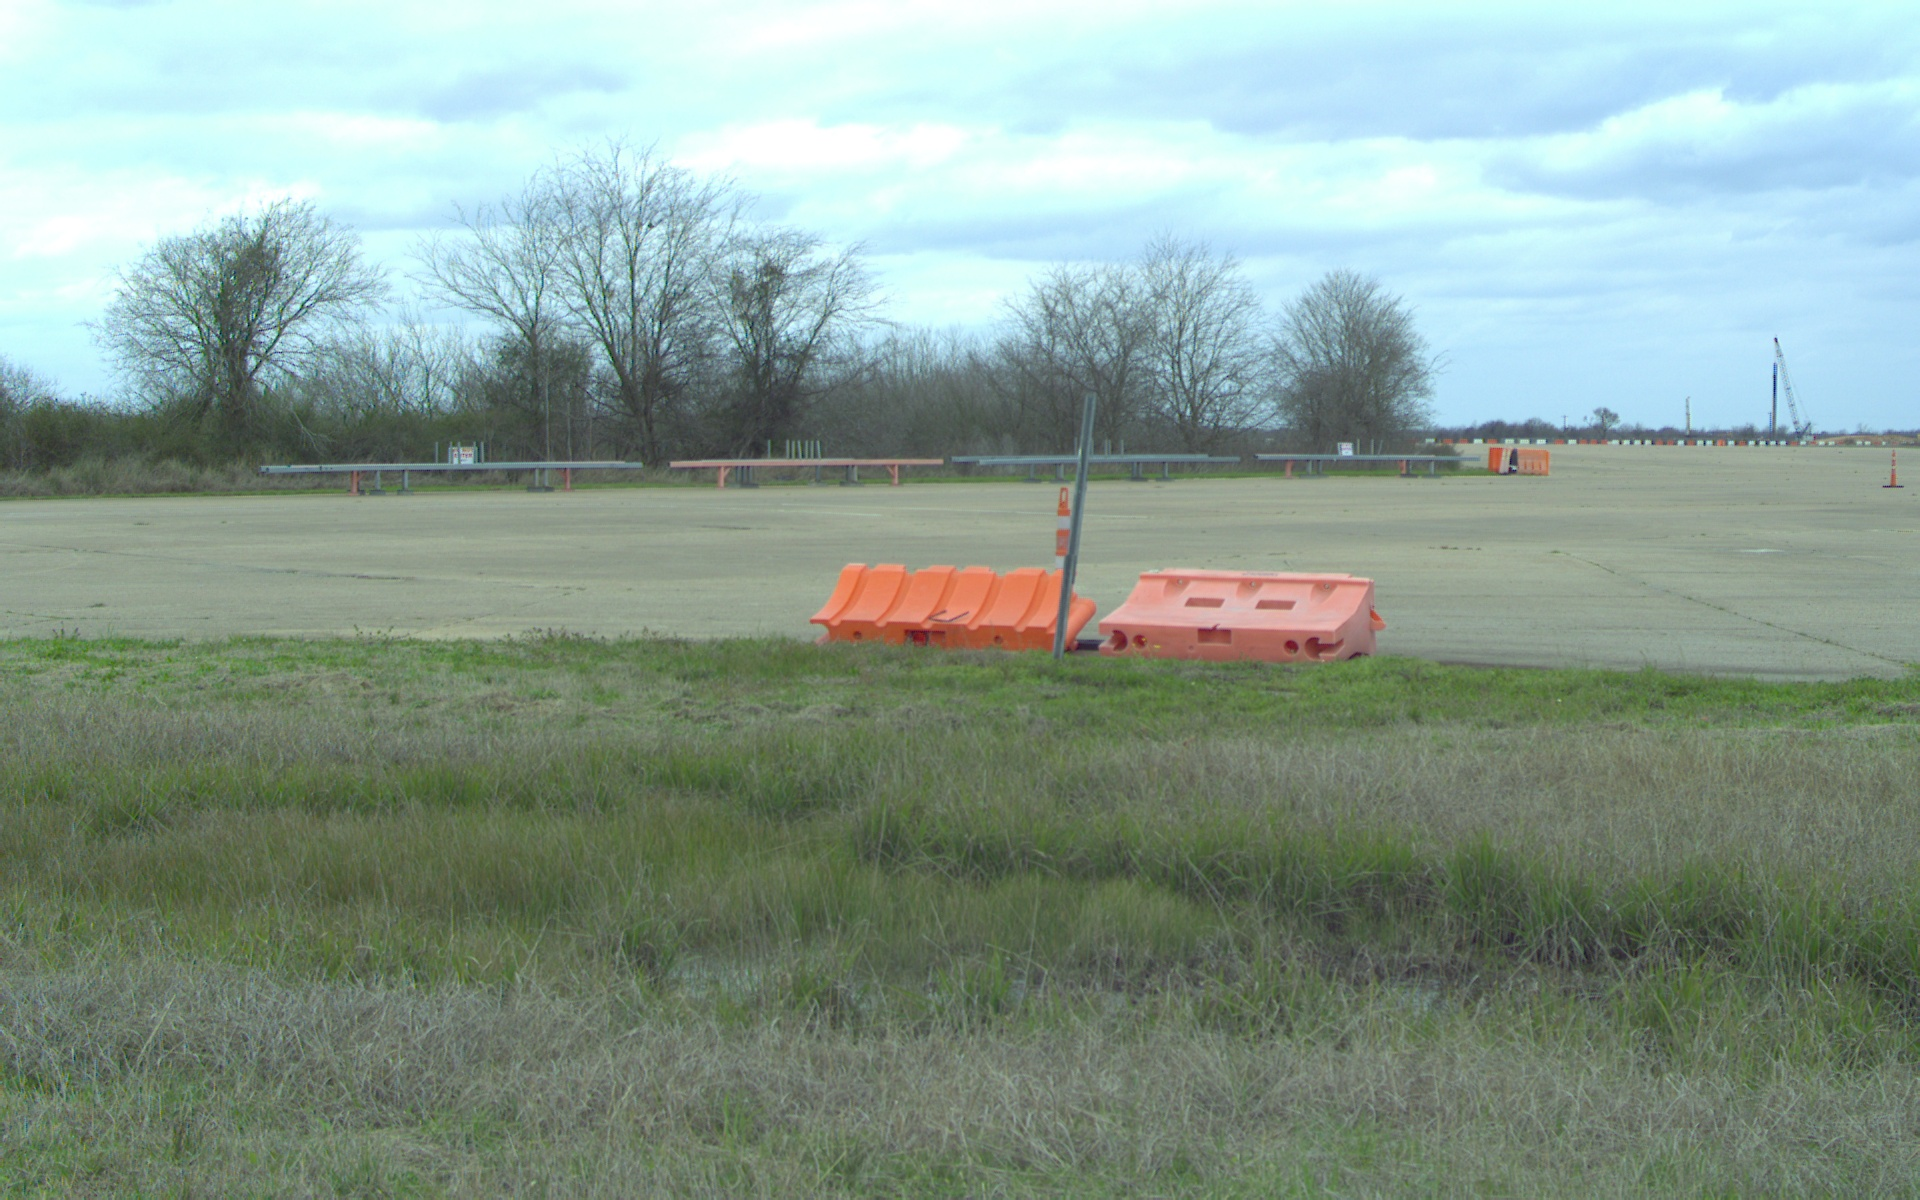

In [ ]:
test_image_dir = os.path.join(extracted_combined, "images", "test")
test_image_filename = random.choice(os.listdir(test_image_dir))
print(test_image_filename)

im = cv2.imread(os.path.join(test_image_dir, test_image_filename))
cv2_imshow(im)

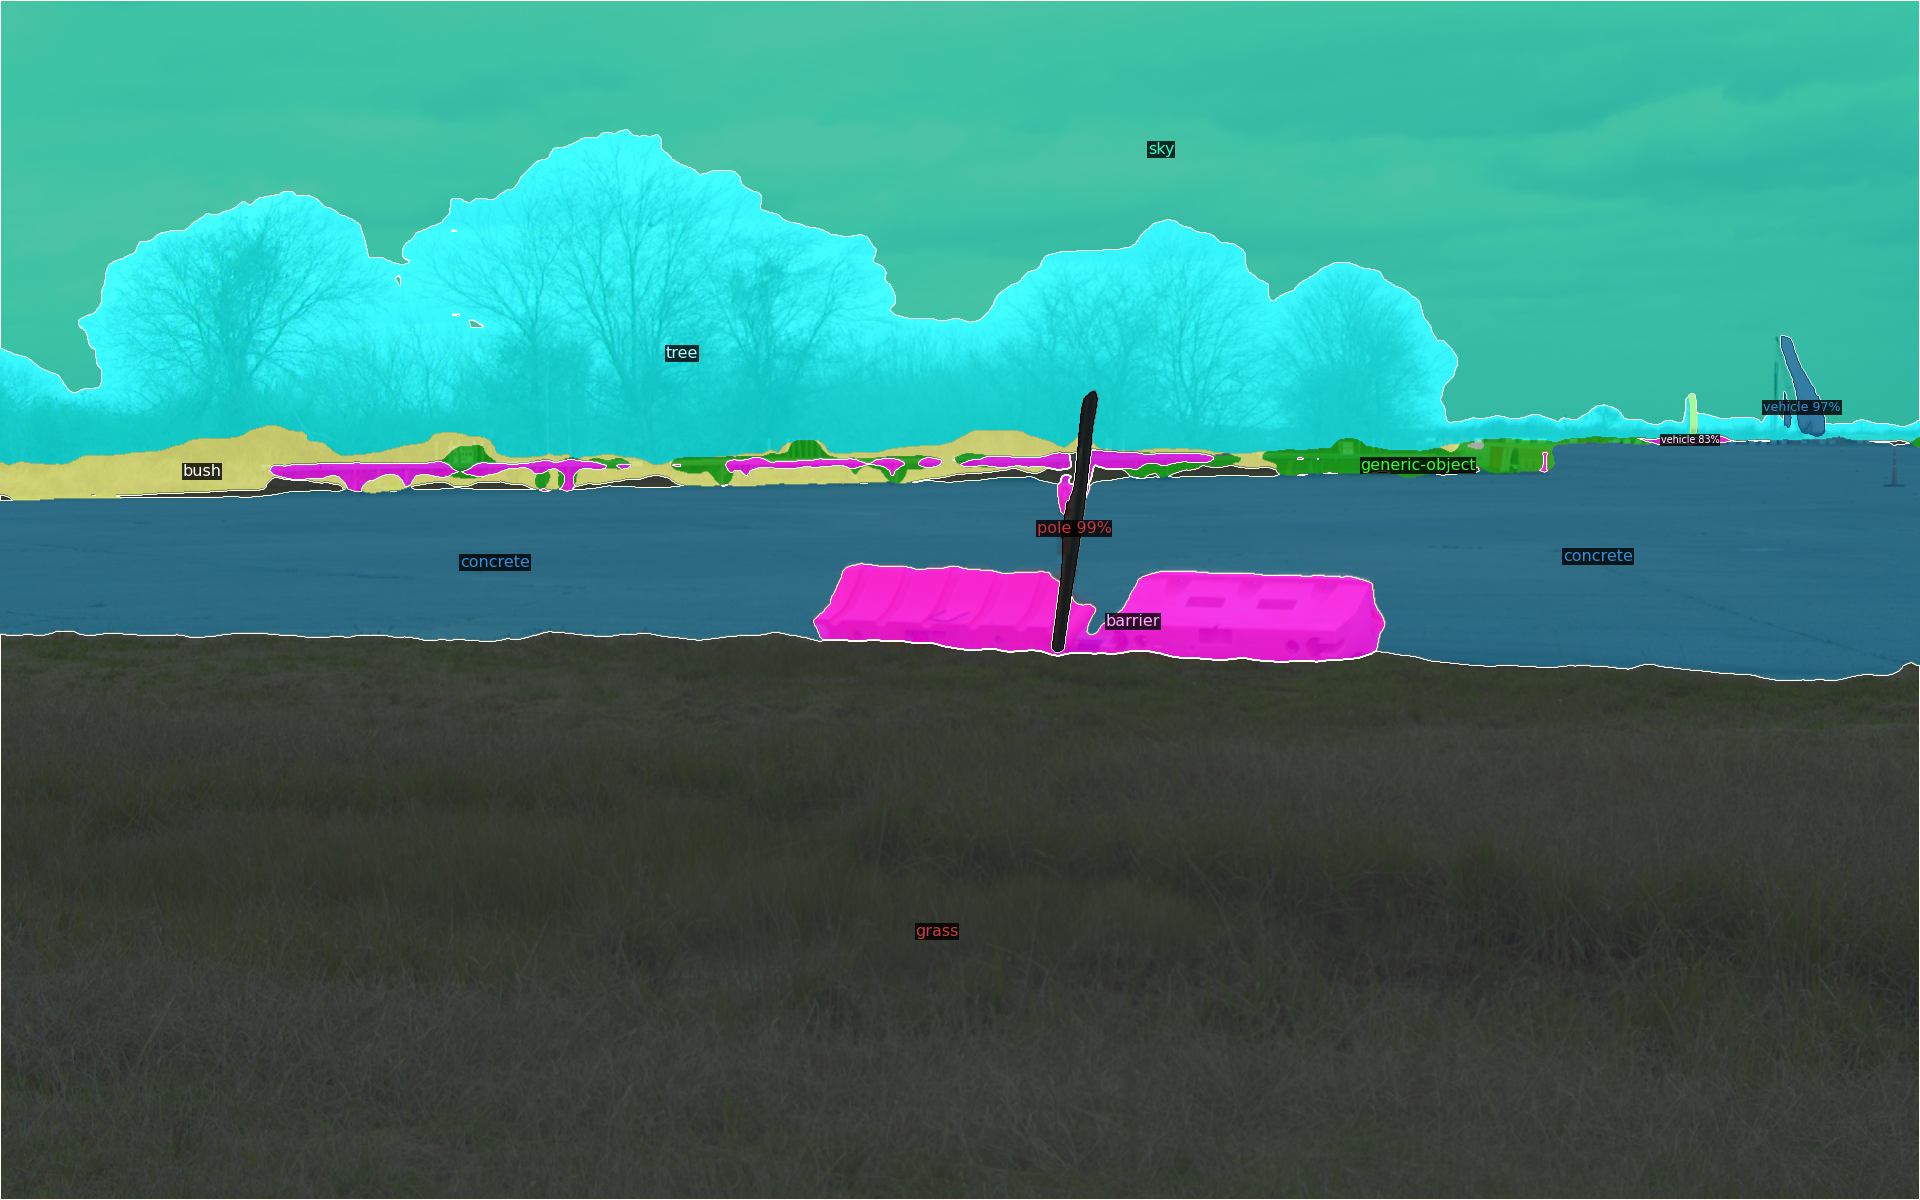

In [ ]:
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(model_cfg.DATASETS.TRAIN[0]), scale=1)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])